##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 3:** Sieci splotowe

**Przykład (1):** Pole recepcyjne i sieci splotowe


W ramach tego notatnika zapoznajmy się z aspektami dotyczącymi pola recepcyjnego oraz budowy modeli sieci splotowej dążącej do uzyskania nowej reprezentacji danych przechodząc do dużych rozmiarów przestrzennych danych w kierunku jednowymiarowego wektora wielu cech.

Wskażmy pakiety, z jakich będziemy korzystać:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme()
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

# You can try to change your Google Colab environment to GPU
print(tf.__version__)

2.6.0


We wcześniejszym notatniku rozważaliśmy operację splotu 2D z wykorzystaniem szeregu klas pakietu TensorFlow. Klasy te operowały na tensorach o specjalnie dobranych rozmiarach, np, (N, H, W, C): N- rozmiar batcha, H-wysokość (l. wierszy), W-szerokość (l. kolumn), C- liczba kanałów.

Powiedzieliśmy również, że celem warstw splotowych jest najczęsciej wyodrębienie cech, które będą podane jako wejście do np. klasyfikatora MLP. Klasyfikator taki operuje na danych jednowymiarowych (np. D-wejść neuronu). Oznacza to, że dla liczby przykładów N (lub liczy przykładów w porcji danych - batchu) potrzebujemy danych o rozmiarze (N, D), gdzie D - liczba cech.

Po zastosowaniu warstw z operację splotu musimy dostosować dane do wymaganego rozmiaru. Najprostszą metodą jest chyba zwykłe przekształceie rozmiaru danych (reshape), realizowane poprzez operacje: np.reshape, tf.reshape, np.flatten(), itp.

In [ ]:
# Data after CNN layer:
layer_after_cnn = np.array([[1,2,3],[4,5,6],[7,8,9]])
# or try an example with depth 2
# layer_after_cnn = np.array([[[1,1],[2,4],[3,6]],[[4,8],[5,10],[6,12]],[[7,14],[8,16],[9,18]]])
print("Input shape:", layer_after_cnn.shape)
flatten_layer_after_cnn = layer_after_cnn.flatten()
print("After flatten shape:", flatten_layer_after_cnn.shape)
print("Flatten data: ", flatten_layer_after_cnn)

Input shape: (3, 3)
After flatten shape: (9,)
Flatten data:  [1 2 3 4 5 6 7 8 9]


Możemy również posłużyć sę funkcjami reshape wykorzystywanymi w ramach specjalnie utworzonej warstwy budowanego modelu - Flatten. Warstwa ta wykonuje stałą operację, tzn. nie ma parametrów podlegających uczeniu. Niemnije, jako warstwa modelu operuje na odpowiednim rozmiarze danych i dlatego dane wejsciowe trzeba odpowiednio przygotować.

In [ ]:
layer_after_cnn = np.array([[1,2,3],[4,5,6],[7,8,9]])
print("Input shape:", layer_after_cnn.shape)
layer_flatten = tf.keras.layers.Flatten()
# Apply Flatten layer
flatten_layer_after_cnn = layer_flatten(layer_after_cnn)
print("After flatten shape:", flatten_layer_after_cnn.shape)

# RESHAPE data to fit the standard API requirements:
# first dimension represent batch size
layer_after_cnn_reshape = layer_after_cnn.reshape((1,3,3))
print("New input shape:", layer_after_cnn_reshape.shape)

# Now we can apply the Flatten operation again!
flatten_layer_after_cnn_r = layer_flatten(layer_after_cnn_reshape)
print("After flatten shape:", flatten_layer_after_cnn_r.shape)

print("Flatten data: ", flatten_layer_after_cnn_r)

Input shape: (3, 3)
After flatten shape: (3, 3)
New input shape: (1, 3, 3)
After flatten shape: (1, 9)
Flatten data:  tf.Tensor([[1 2 3 4 5 6 7 8 9]], shape=(1, 9), dtype=int64)


Projektują model sieci splotowej przechodzimy od danych przestrzennych do wektora cech. Przetwarzanie danych z tym związane może odbywać się poprzez kaskadę warstw splotowych bez stosowania dopełniania danych (no padding). Wówczas po każdym kroku uzyskamy rozmiar danych wyjściowych mniejszy przestrzennie o brzeg, zgodnie z wcześniej omówionymi parametrami operacji "splotu": kernel size, stride, dilation rate, itp. Stosując K filtrów, uzyskamy dane dla D cech. Stąd po pewnym zestawie warstw splotowych przejdziemy od wymiaru (H, W, Din) do (1, 1, D). Spłaszczenie takiego tensora pozwoli nam uzyskać wektor o D cechach podawany na wejście MLP.

Warto zauważyć, że K warstw splotowych i dobór parametrów wpływa na pole recepcyjne modelu (omówione w czasie prezdentacji).

W celu redukcji parametrów podlegających uczenia a jednoześnie zapewneiniu redukcji przestrzennej danych (i uniezależmnieniu się od loklalnych, niewielkich zmian danych) można wprowadzić do modelu CNN nowe warstwy, realizujące przestrzenną, lokalną agregację danych (w okreśłonym oknie - podobnie jak splot). Wyznaczmy w oknie np. (2x2) wartośc maksymalną lub średnią i w ten sposób redukujemy wymiar przestrzenny. Jednocześnie, patrząc od strony wyjścia modelu, zwiększamy pole recepcyjne dla wartości z kolejnych warstw.

Agragacja realizowana jest przez określone klasy, np. MaxPooling2D, AveragePooling2D i co ważne, redukuje wymiar przestrzenny lecz NIE ZMIENIA liczby kanałów - działw w każdym kanale oddzielnie.



Source data: 
 [[[[ 1  1]
   [ 2  4]
   [ 3  6]]

  [[ 4  8]
   [ 5 10]
   [ 6 12]]

  [[ 7 14]
   [ 8 16]
   [ 9 18]]]]


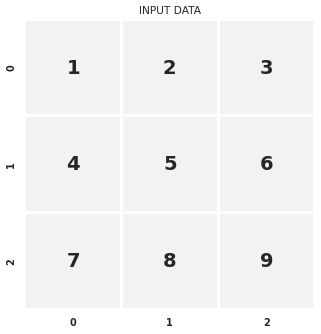

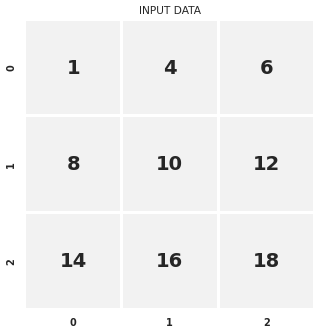

After pooling shape: (1, 2, 2, 2)
Pooling data:  tf.Tensor(
[[[[ 5 10]
   [ 6 12]]

  [[ 8 16]
   [ 9 18]]]], shape=(1, 2, 2, 2), dtype=int64)


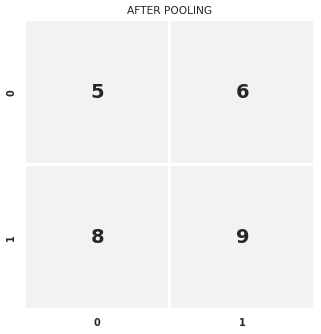

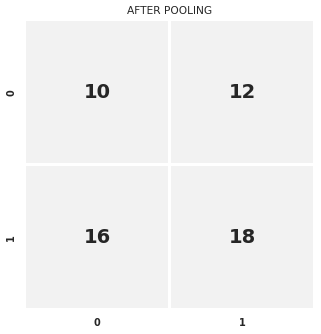

In [ ]:
# Data after CNN layer:
layer_after_cnn = np.array([[[1,1],[2,4],[3,6]],[[4,8],[5,10],[6,12]],[[7,14],[8,16],[9,18]]])
# Shape (3,3,2) - depth = 2
# Reshape to add batch size
layer_after_cnn_reshape = layer_after_cnn.reshape((1,3,3,2))

# Define Pooling layer - try also with AveragePooling2D
layer_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                             strides=(1, 1),
                                             padding='valid')
pooling_layer_after_cnn = layer_pooling(layer_after_cnn_reshape)

print("Source data: \n",layer_after_cnn_reshape)

fig1 = plt.figure(figsize=(9, 6), dpi=64)
# plt.style.use('fivethirtyeight')
matplotlib.rc('font', **font)

ax1 = sns.heatmap(layer_after_cnn[:,:,0],
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)


ax1.set(title="INPUT DATA")
plt.show()

fig2 = plt.figure(figsize=(9, 6), dpi=64)
ax2 = sns.heatmap(layer_after_cnn[:,:,1],
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)

ax2.set(title="INPUT DATA")
plt.show()

print("After pooling shape:", pooling_layer_after_cnn.shape)
print("Pooling data: ", pooling_layer_after_cnn)

fig3 = plt.figure(figsize=(9, 6), dpi=64)
ax3 = sns.heatmap(pooling_layer_after_cnn[0,:,:,0],
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)
ax3.set(title="AFTER POOLING")
plt.show()

fig4 = plt.figure(figsize=(9, 6), dpi=64)
ax4 = sns.heatmap(pooling_layer_after_cnn[0,:,:,1],
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)
ax4.set(title="AFTER POOLING")
plt.show()

W powyższym przykładzie pracowaliśmy z danymi o dwóch kanałach, dlatego uzyskaliśmy jako wynik tensor również o dwóch kanałach. Ponieważ nasze dane wejsciowe miały rozmiar przestrzenny 3x3, a operacja agregacji operowała na oknie 2x2 i kroku 1 (częsciej stosuje się krok równy rozmiarowi okna operacji agregacji - czyli w tym przypadku byłoby to (2,2)) dlatego dla każdego kanału (macierzy 3x3) istnieją 4 pozycje nałożenia maski (2x2). Stąd wynik operacji ma rozmiar (2x2) dla dwóch kanałów i jednego zbioru danych (N=1)), razem (1,2,2,2).

Jeśli operację agregacji chcielibyśmy przeprowadzić dla okna o takim samym rozmiarze jak dane (HxW) wówczas uzyskamy wynik globalnej agregacji. W takim przypadku możemy również wykorzystać dedykowane klasy jak GlobalMaxPooling, dla których nie podajemy paramterów typu rozmiar okna, itp.

In [ ]:
# Data after CNN layer:
layer_after_cnn = np.array([[[1,1],[2,4],[3,6]],[[4,8],[5,10],[6,12]],[[7,14],[8,16],[9,18]]])
layer_after_cnn_reshape = layer_after_cnn.reshape((1,3,3,2))

# layer_agg = tf.keras.layers.Flatten()
# layer_agg = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))
layer_agg = tf.keras.layers.GlobalMaxPooling2D()

flatten_layer_after_cnn = layer_agg(layer_after_cnn_reshape)

print("After flatten shape:", flatten_layer_after_cnn.shape)
print("Flatten data: ", flatten_layer_after_cnn)

After flatten shape: (1, 2)
Flatten data:  tf.Tensor([[ 9 18]], shape=(1, 2), dtype=int64)


Jak napisaliśmy wcześniej dążymy do takiego efektu, aby na wyjściu bloku ekstrakcji cech uzyskać wektor o określonej liczbie cech D, bez danych przestrzennych (lub tensor z uwzględnieniem liczby przykładów N - (N, D)).

In [ ]:
# Data after CNN layer:
layer_after_cnn = np.array([[[1,1,1],[2,4,6],[3,6,9]],
                            [[4,8,12],[5,10,15],[6,12,18]],
                            [[7,14,21],[8,16,24],[9,18,27]]]).astype('float')

layer_after_cnn_reshape = layer_after_cnn.reshape((1,3,3,3))

# layer_agg = tf.keras.layers.Flatten()
# layer_agg = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))
# layer_agg = tf.keras.layers.GlobalMaxPooling2D()

# w_fixed = np.ones((3,3,3,1)).astype('float')
# layer_agg = tf.keras.layers.Conv2D(filters=1,
#                                  kernel_size=(3, 3),
#                                  use_bias=False,
#                                  weights=[w_fixed])

# layer_agg = tf.keras.layers.DepthwiseConv2D(
#                                  kernel_size=(3, 3),
#                                  use_bias=False,
#                                  weights=[w_fixed])

no_of_filters = 3
w_fixed_3 = np.ones((3,3,3,no_of_filters)).astype('float')
layer_agg = tf.keras.layers.Conv2D(filters=no_of_filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 weights=[w_fixed_3])

flatten_layer_after_cnn = layer_agg(layer_after_cnn_reshape)

print("After flatten shape:", flatten_layer_after_cnn.shape)
print("Flatten data: ", flatten_layer_after_cnn)

After flatten shape: (1, 1, 1, 3)
Flatten data:  tf.Tensor([[[[267. 267. 267.]]]], shape=(1, 1, 1, 3), dtype=float32)


**Poznaliśmy szereg rodzajów warstw, z których możemy zbudować architekturę (model) sieci splotowej.**

Spróbujmy teraz zaproponować różne modele tak, aby sprawdzić znaczenie poszczególnych warstw oraz i zaobserwować proces uczenia wag warstw splotowych.

Posłużmy się przykładem znanego nam zbioru danych CIFAR-10.

170508288/170498071 [==============================] - 11s 0us/step
True original label : 6 frog


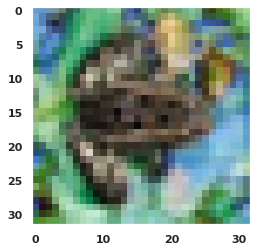

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


Sprawdźmy podstawowe infortmacje o wczytanym zbiorze.

Dokonajmy także konwersji metody reprezentacji etykiet klas do postaci wektora wartości binarnych (ang. one hot encoding).

In [ ]:
# Show the shape of input data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("X train dataset shape: ", x_train.shape)
print("Max value in X train: ", np.max(x_train))

print("X test dataset shape: ", x_test.shape)


no_of_classes = len(np.unique(y_train))
print("No of clases: ", no_of_classes)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


X train dataset shape:  (50000, 32, 32, 3)
Max value in X train:  255.0
X test dataset shape:  (10000, 32, 32, 3)
No of clases:  10


Przeprowadźmy prostą normalizację danych.

In [ ]:
# Normalize image data

max_train = np.max(x_train)
x_train = x_train / max_train
x_test = x_test / max_train

print("Max value in X train: ", np.max(x_train))
print("Max value in X train: ", np.max(x_test))

Max value in X train:  1.0
Max value in X train:  1.0


Zdefiniujmy teraz prostą architekturę modelu głębokiego. Wykorzystajmy jedną warstwę splotową, warstwę "spłaszczenia danych" oraz dwie warstwy tworzące nasz wielowarstwowy perceptron.

In [ ]:
# Use Keras High Level API to solve our problem

# 1. Define the Model
keras_model = tf.keras.Sequential([
    # CNN:
    tf.keras.layers.Conv2D(1, kernel_size=3, activation='relu',
                           input_shape=x_train.shape[1:], name="conv2D_1"),
    tf.keras.layers.Flatten(),  # make data flat to use dense layers
    # MLP:
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(no_of_classes, activation='softmax')

  ])

# Show the model definition (layers, etc.)
keras_model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 30, 30, 1)         28        
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                45050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 45,588
Trainable params: 45,588
Non-trainable params: 0
_________________________________________________________________


Jak widaź model składa się z 4 warstw (pomijając warstwę wejścia). Pierwsza warstw to warstwa splotowa. Zauważmy, że:
- Rozmiar wyjścia jest (None, 30, 30, 1). None oznacza, że rozmiar porcji danych będzie znany później i na razie nie jest istotny. Rozmiar przestrzennyhn (30x30) wynika z faktu, że rozmian maski splotu to 3x3 i nie stosujemy dopełnienia wartości  (czyli brzeg z każdej strony: int(3/2)=1, tj. dla wierszy i dla kolumn: 32 - 2*1. Nasz model ma tylko jeden filtr (jedną maskę) i dlatego ostatni elementy rozmiar ma wartość 1.
- Liczba parametrów pierwszej warstwy to 28. Domyślnie implementowana operacja "splotu" współdzieli wagi. Pamiętamy z wcześniejszych przykładów, że rozmiar wag ustalany jest jako: (kernel_height, kernel_width, input_depth, number_of_filters). W naszym przypadku:  (3,3,3,1) -> liczba parametrów 3\*3\*3\*1= 27 PLUS BIAS (ponieważ domyślnie dla warstwy Conv2D mamy use_bias=True). Dlatego łącznie mamy 27+1=28.

Druga wastwa jest właściwie prostą operacją, w ramach której nie mamy parametrów do uczenia. W efekcie uzyskujemy płaski zestaw wartości po filtracji.

Trzecia warstwa to klasyczna zestaw 50 jednostek (neuronów) o w pełmni połączonych wejsciach z wszystkimi próbkami uzyskanymi z poprzedniej warstwy. Na wejście każdego z 50 neuronów trafiają wszystkie 900 wartości (30*30) stanowiące wynik filtracji jednym filtrem. Mamy zatem 900 wag do uczenia. Oczywiscie plus bias - łączie 901. Ponieważ stosujemy 50 takich neuronów uzyskujemy łączie 901*50=45050 parametrów.

Wyjście trzeciej warstwy to rezultat działań przeprowadzanych przez 50 jednostek (neuronów). Wyniki te trafiają na 10 neruonów ostatniej warstwy, która jak się można domyśleć ma (50+1)*10 = 510 parametrów do uczenia.

Dlaczego 10 neuronów na wyjściu? Ponieważ mamy 10 klas - wyjście każdego neuronu to "głos" za daną klasą.

Przeprowadźmy teraz proces uczenia wykrzystując środowisko TF/Keras.

In [ ]:
# Set some training parameters
batch_size = 64
epochs = 10
eta = 0.01  #  (initial) learning rate

Epoch 1/10
782/782 [==============================] - 31s 4ms/step - loss: 2.3035 - accuracy: 0.0987
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 2.3030 - accuracy: 0.0984
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 2.3025 - accuracy: 0.1013
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 1.9980 - accuracy: 0.2687
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 1.8354 - accuracy: 0.3332
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 1.7687 - accuracy: 0.3563
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 1.7232 - accuracy: 0.3758
Epoch 8/10
782/782 [==============================] - 3s 4ms/step - loss: 1.6893 - accuracy: 0.3913
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 1.6603 - accuracy: 0.4019
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 1.6359 - accuracy: 0.411

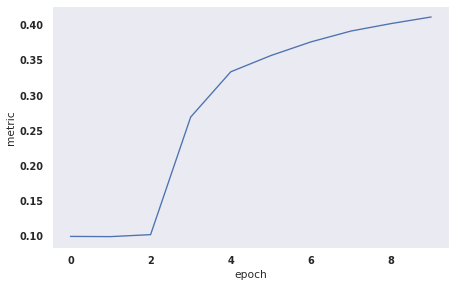

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=eta, momentum=0.9, nesterov=True)

# 2. Set the training parameters
keras_model.compile(
    # Select optimizer
    optimizer=sgd,
    loss='categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
)

# 3. Start the training with the specified hyperparameters
# (and store the history of training)
# Try with much more epochs in your experiments
history = keras_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

# Show history
matplotlib.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(8, 5), dpi=64)
f1 = f.add_subplot(111)
f1.set_xlabel('epoch')
f1.set_ylabel('metric')
plt.plot(history.history['accuracy'])

plt.show()

Możemy zobserwować, że w kolejnych epokach uzyskiwane byłych doraz większe wartości wybranej miary - dokładności. Niemniej wyniki są bardzo słabe. Architektura naszego modelu nie jest zapewne dobrze dobrana do rozpatrywanego problemu. Oczywiście w kolejnych krokach będziemy taki model rozbudowywać.

Na razie jednak przyjrzyjmy się pewnym aspektom uzyskanego modelu: architektura + nauczone wartości wag. Jak odczytać wartości wag dla naszego modelu?




Shape of the layer output: (None, 30, 30, 1)
Shape of the layer weights - without bias: (3, 3, 3, 1)
Shape of the bias tensor: (1,)
(2, 30, 30, 1)


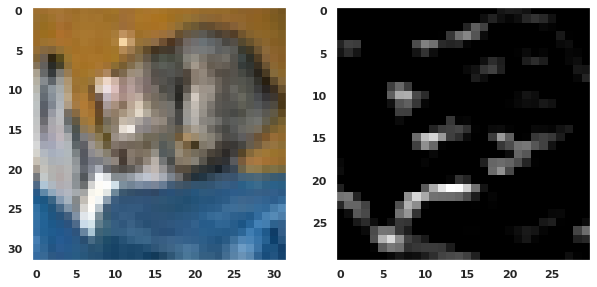

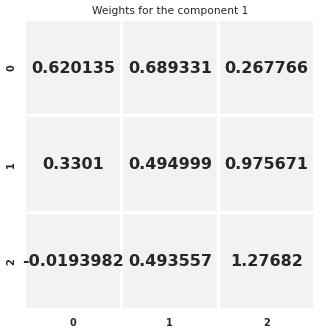

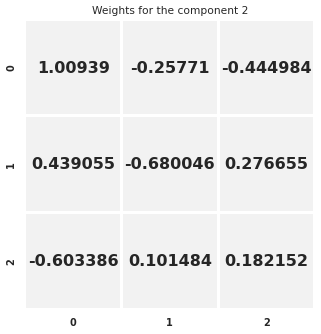

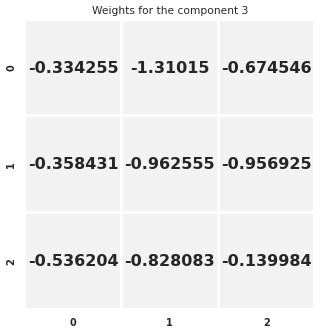

In [ ]:
# Get intance of the tf.keras.layers.Layer class:
# keras_model.layers[1] or keras_model.get_layer("conv2D_1")

layer_output = keras_model.get_layer("conv2D_1").output
layer_weights = keras_model.get_layer("conv2D_1").get_weights()

# Show output of the layer and weights of the layer
print("Shape of the layer output:", layer_output.shape)
print("Shape of the layer weights - without bias:", layer_weights[0].shape)
print("Shape of the bias tensor:", layer_weights[1].shape)

simple_model = tf.keras.models.Model(inputs=keras_model.input, outputs=layer_output)
activations = simple_model.predict(x_test[:2])
print(activations.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow((255.*x_test[0]).astype('int'))

axs[0].grid(False)
axs[1].imshow(activations[0].reshape(activations.shape[1:3]),cmap=plt.cm.gray)
axs[1].grid(False)
plt.show()

# Show weights for each depth component

figW1 = plt.figure(figsize=(9, 6), dpi=64)
axW1 = sns.heatmap(layer_weights[0][0].reshape(3,3),
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)
axW1.set(title="Weights for the component 1")
plt.show()

figW2 = plt.figure(figsize=(9, 6), dpi=64)
axW2 = sns.heatmap(layer_weights[0][1].reshape(3,3),
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)
axW2.set(title="Weights for the component 2")
plt.show()

figW3 = plt.figure(figsize=(9, 6), dpi=64)
axW3 = sns.heatmap(layer_weights[0][2].reshape(3,3),
                  cbar=False,
                  square=True,
                  annot=True,
                  fmt='g',
                  cmap=ListedColormap(['#F2F2F2']),
                  linewidths=2.)
axW3.set(title="Weights for the component 3")
plt.show()


Wypróbujmy teraz inną architekturę: wprowadźmy więcej filtrów oraz więcej warstw splotowych:

In [ ]:
# Use Keras High Level API to solve our problem

# Define the Model
keras_model_2 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                           input_shape=x_train.shape[1:], name="conv2D_2"),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                            name="conv2D_3"),
    tf.keras.layers.Conv2D(1, kernel_size=3, activation='relu',
                            name="conv2D_4"),
    tf.keras.layers.Flatten(),  # make data flat to use dense layers
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(no_of_classes, activation='softmax')

  ])

# Show the model definition (layers, etc.)
keras_model_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_2 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2D_4 (Conv2D)            (None, 26, 26, 1)         145       
_________________________________________________________________
flatten_2 (Flatten)          (None, 676)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                33850     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 37,273
Trainable params: 37,273
Non-trainable params: 0
__________________________________________________

In [ ]:
# Set the training parameters
keras_model_2.compile(
    # Choose the optimizer
    optimizer=sgd,
    loss='categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
)

# Start the training with the specified hyperparameters
# (and store the history of training)
# Try with much more epochs in your experiments
history = keras_model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)



Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3032 - accuracy: 0.0991
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3029 - accuracy: 0.1011
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3030 - accuracy: 0.1001
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3031 - accuracy: 0.0973
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3031 - accuracy: 0.0978
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3030 - accuracy: 0.1004
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3031 - accuracy: 0.0960
Epoch 8/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3030 - accuracy: 0.0986
Epoch 9/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3030 - accuracy: 0.0977
Epoch 10/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3030 - accuracy: 0.0979

Shape of the layer output: (None, 26, 26, 1)
Shape of the layer weights - without bias: (3, 3, 16, 1)
Shape of the bias tensor: (1,)
(2, 26, 26, 1)


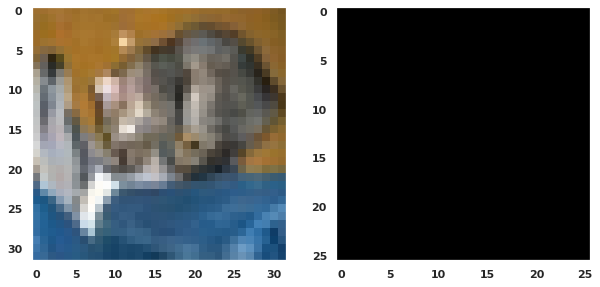

In [ ]:
# Get intance of the tf.keras.layers.Layer class:
# keras_model.layers[1] or keras_model.get_layer("conv2D_1")

layer_output = keras_model_2.get_layer("conv2D_4").output
layer_weights = keras_model_2.get_layer("conv2D_4").get_weights()

# Show output of the layer and weights of the layer
print("Shape of the layer output:", layer_output.shape)
print("Shape of the layer weights - without bias:", layer_weights[0].shape)
print("Shape of the bias tensor:", layer_weights[1].shape)

simple_model = tf.keras.models.Model(inputs=keras_model_2.input, outputs=layer_output)
activations = simple_model.predict(x_test[:2])
print(activations.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(x_test[0])
axs[0].grid(False)
axs[1].imshow(activations[0].reshape(activations.shape[1:3]),cmap=plt.cm.gray)
axs[1].grid(False)
plt.show()

Uzyskane wyniki wciąż nie są najlepsze (i mogą się znacznie różnić pomiędzy kolejnymi treningami, łącznie z brakiem zbieżności).

W czasie prezentacji poznaliśmy jeszcze inny rodzaj wartstw stosowanych w sieciach splotowych: warstwy redukcji danych (ang. pooling). Przypomnijmy, że warstwy te wykonują prostą operację redukcji danych przestrzennych prowadząc do uogólniana cech i zwiększenia pola recepcyjnego. W klasycznym podejściu nie posiadają parametrów podlegających uczeniu. Typowe wersje lokalnej (w oknie) redukcji danych to:

- Max Pooling - dla danego okna (rozmiaru maski), np. 2x2, wybierz wartość maksymalną - wyjście: 1 wartość maksymalna (zamiast 4 wartości).
- Average Pooling - dla danego okna (rozmiaru maski), np. 2x2, oblicz wartość średnią - wyjście: 1 wartość średnia (zamiast 4 wartości).

Podstawowymi hiperparametrami dla tych operacji są rozmiar okna (ang. kernel size) oraz krok (ang. stride).

Zastosujmy te operacje w naszej architekturze modelu głębokiego.



In [ ]:

# Use Keras High Level API to solve our problem

# Define the Model
keras_model_3 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                           input_shape=x_train.shape[1:], name="conv2D_5"),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                            name="conv2D_6"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                           name="conv2D_7"),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                            name="conv2D_8"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    # make data flat using average in spatial dimension
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(no_of_classes, activation='softmax')

  ])

# Show the model definition (layers, etc.)
keras_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_5 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2D_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2D_7 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2D_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)              

In [ ]:
# Set the training parameters
keras_model_3.compile(
    # Choose the optimizer
    optimizer= sgd,
    loss='categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
)

# Start the training with the specified hyperparameters
# (and store the history of training)
# Try with much more epochs in your experiments
history = keras_model_3.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)


Epoch 1/10
782/782 [==============================] - 7s 8ms/step - loss: 1.6690 - accuracy: 0.3897
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 1.2536 - accuracy: 0.5523
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 1.0694 - accuracy: 0.6239
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9470 - accuracy: 0.6661
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8556 - accuracy: 0.6997
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7767 - accuracy: 0.7270
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7212 - accuracy: 0.7484
Epoch 8/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6683 - accuracy: 0.7651
Epoch 9/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6257 - accuracy: 0.7813
Epoch 10/10
782/782 [==============================] - 6s 8ms/step - loss: 0.5834 - accuracy: 0.7948

Uzyskaliśmy względnie dobre wyniki dokładności modelu w procesie uczenia (proszę zauważyć, że zmieniliśmy również kilka innych parametrów).

Sprawdźmy teraz jakie wyniki uzyskuje model dla danych, których wcześniej nie widział - dla danych testowych.


Run evaluation
313/313 [==============================] - 1s 4ms/step - loss: 0.9079 - accuracy: 0.6983
Evaluation result - loss:  0.9078916311264038
Evaluation result - accuracy:  0.6983000040054321

Show some test results
True original label : 8 ship

Show 'probabilities': 
[1.38516014e-04 1.10068657e-01 4.76871982e-08 1.14147724e-07
 2.31412042e-10 3.68284819e-10 5.34516387e-09 3.90342481e-11
 8.73777092e-01 1.60156190e-02]

Predicted label:  ship


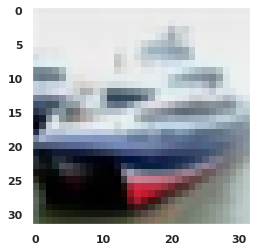

In [ ]:
# Test data - the same as for training data

test_examples = y_test.shape[0]
# test_examples = 20

y = keras_model_3.predict(x_test[:test_examples])

print("\nRun evaluation")
loss, accuracy = keras_model_3.evaluate(x_test[:test_examples],
                                      y_test[:test_examples])

print("Evaluation result - loss: ", loss)
print("Evaluation result - accuracy: ", accuracy)

# print("True (binary) labels: ")
# print(y_test[:test_examples])
# print("Model 'probabilities': ")
# print(y[:test_examples])

print("\nShow some test results")
example = 1
img = ((x_test[example]*255.0).reshape(32,32,3)).astype(int)
plt.imshow(img)
plt.grid(False)

class_id = np.argmax(y_test[example])
print("True original label :", class_id, class_names[class_id])
print("\nShow 'probabilities': ")
print(y[example])

print("\nPredicted label: ", class_names[np.argmax(y[example])])


Wyniki fazy testowania są zbieżne z rezultatami treningu. Oczywiście moglibyśmy zwiększyć liczbę epok, poszukiwać innych architektur (architektura jako hipoteza do weryfikacji), poszukiwać najlepszych wartości hiperparametrów, itp.

W kolejnym materiale zajmiemy się klasycznymi architekturami splotowych sieci głębokich. Poznamy nowe rodzaje warstw, topologii połączeń, itp.

Zachęcam jak zawsze do eksperymentowania z przedstawionymi w tym notatniku przykładami.

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>